<div align="center">

## Projekt ML

</div>

Pearson z targetem:
 Time_taken(min)                1.000000
Delivery_person_Age            0.292708
Delivery_location_latitude     0.014243
Restaurant_latitude            0.013981
Restaurant_longitude           0.007821
Delivery_location_longitude    0.007625
Delivery_person_Ratings       -0.331103
Name: Time_taken(min), dtype: float64 

Spearman z targetem:
 Time_taken(min)                1.000000
Delivery_person_Age            0.309447
Delivery_location_latitude     0.030495
Delivery_location_longitude    0.028469
Restaurant_latitude            0.014593
Restaurant_longitude           0.008518
Delivery_person_Ratings       -0.289439
Name: Time_taken(min), dtype: float64 

count    45593.000000
mean        99.303911
std       1099.731281
min          1.465067
25%          4.663493
50%          9.264281
75%         13.763977
max      19692.674606
Name: distance_km, dtype: float64
Corr(distance_km, time) - pełne dane (Pearson): -0.002508067141567969
Corr(distance_km, time) - clip < 50 k

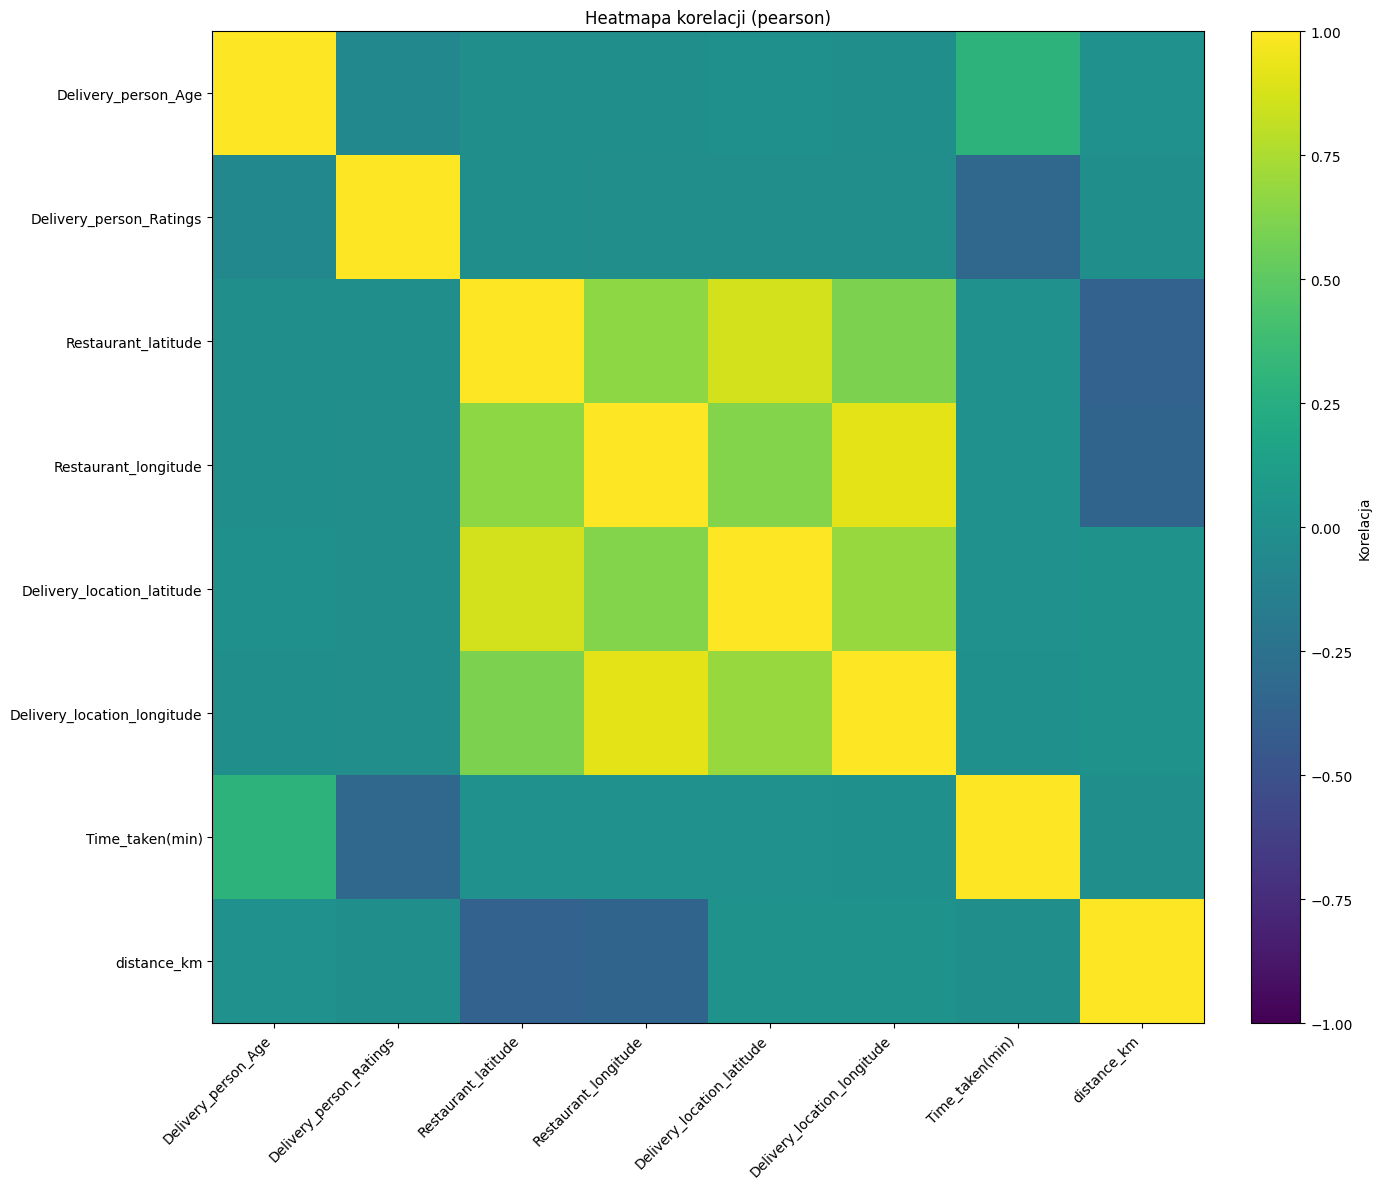

                             Time_taken(min)  Delivery_person_Age  \
Time_taken(min)                     1.000000             0.292708   
Delivery_person_Age                 0.292708             1.000000   
Delivery_person_Ratings            -0.331103            -0.067449   
distance_km                        -0.002508             0.014243   
Restaurant_latitude                 0.013981            -0.001955   
Restaurant_longitude                0.007821            -0.006796   
Delivery_location_latitude          0.014243             0.002359   
Delivery_location_longitude         0.007625            -0.000593   

                             Delivery_person_Ratings  distance_km  \
Time_taken(min)                            -0.331103    -0.002508   
Delivery_person_Age                        -0.067449     0.014243   
Delivery_person_Ratings                     1.000000    -0.006230   
distance_km                                -0.006230     1.000000   
Restaurant_latitude              

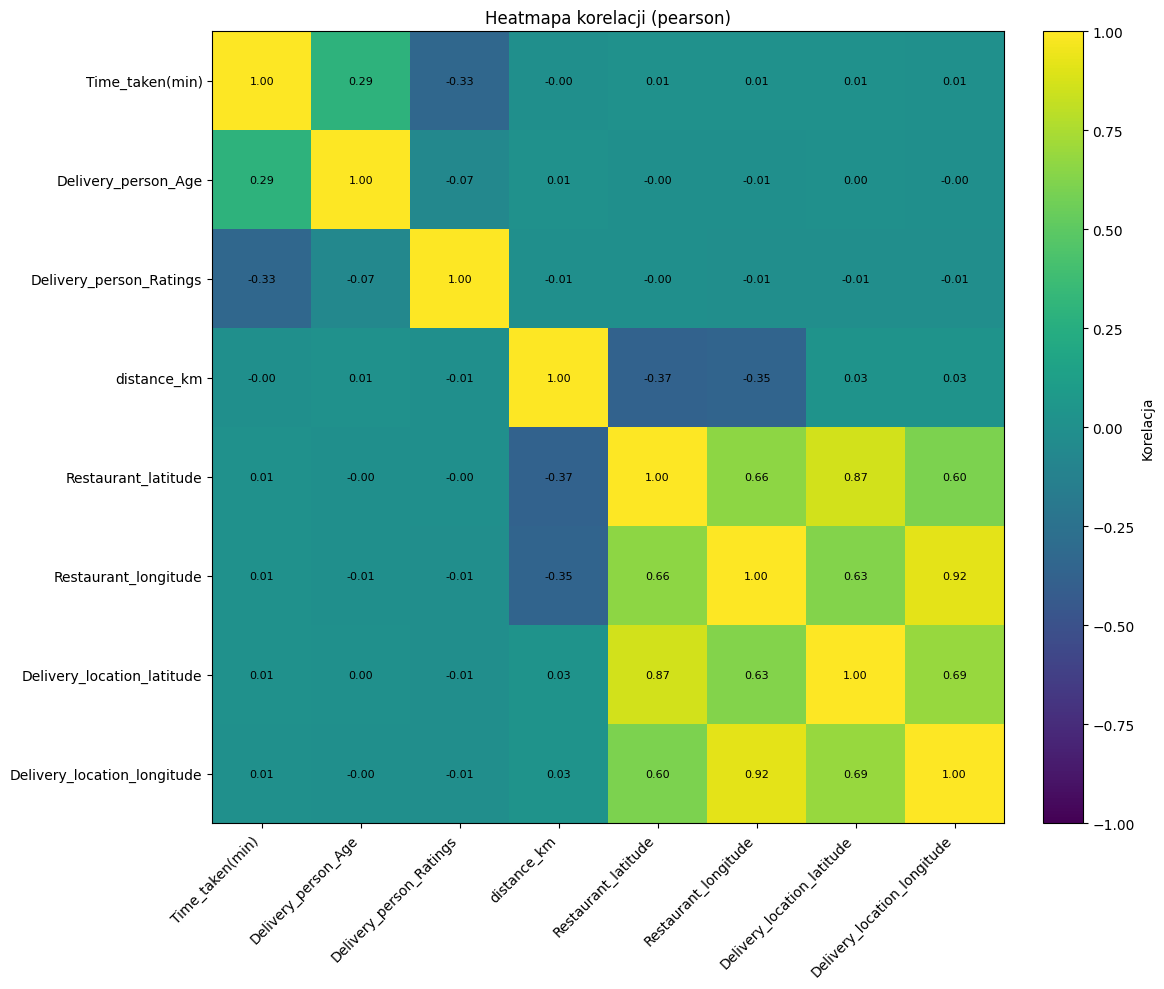

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [20]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, asin, sqrt

df = pd.read_csv("deliverytime.csv")

target = "Time_taken(min)"

# 1) Korelacje dla liczbowych
num_cols = df.select_dtypes(include=[np.number]).columns
pearson = df[num_cols].corr(method="pearson")[target].sort_values(ascending=False)
spearman = df[num_cols].corr(method="spearman")[target].sort_values(ascending=False)

print("Pearson z targetem:\n", pearson, "\n")
print("Spearman z targetem:\n", spearman, "\n")

# 2) Haversine distance jako feature
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

dist_km = np.vectorize(haversine_km)(
    df["Restaurant_latitude"].values,
    df["Restaurant_longitude"].values,
    df["Delivery_location_latitude"].values,
    df["Delivery_location_longitude"].values,
)
df["distance_km"] = dist_km

print(df["distance_km"].describe())

# Pearson na pełnych danych (bez przycinania)
corr_raw = df["distance_km"].corr(df[target], method="pearson")
print("Corr(distance_km, time) - pełne dane (Pearson):", corr_raw)

# (opcjonalnie) Pearson po clip < 50 km dla porównania
df_clip = df[df["distance_km"] < 50].copy()
corr_clip = df_clip["distance_km"].corr(df_clip[target], method="pearson")
print("Corr(distance_km, time) - clip < 50 km (Pearson):", corr_clip)

print("Corr(distance_km, time) po clip < 50km:",
      df_clip[["distance_km", target]].corr().iloc[0, 1])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import plotly.express as px

def plot_corr_heatmap_plotly(
    df: pd.DataFrame,
    cols=None,
    method: str = "pearson",
    title: str | None = None,
    width: int = 950,
    height: int = 800,
    show_values: bool = False,
    value_fmt: str = ".2f",
):
    """
    Heatmapa korelacji (Plotly) na ciemnym tle.
    - df: DataFrame
    - cols: lista kolumn; jeśli None -> wszystkie numeryczne
    - method: 'pearson' | 'spearman' | 'kendall'
    - show_values: czy wypisywać wartości w komórkach
    Zwraca: (corr_df, fig)
    """

    # 1) Wybór kolumn
    if cols is None:
        data = df.select_dtypes(include=[np.number]).copy()
    else:
        data = df[cols].copy()

    # 2) Korelacja
    corr = data.corr(method=method)

    # 3) Tekst w komórkach
    text_auto = value_fmt if show_values else False

    # 4) Heatmapa
    fig = px.imshow(
        corr,
        zmin=-1,
        zmax=1,
        color_continuous_scale="RdBu_r",
        text_auto=text_auto,
        aspect="auto",
    )

    # 5) Styl: ciemne tło, duży pogrubiony tytuł
    if title is None:
        title = f"Macierz korelacji ({method})"

    fig.update_layout(
        template="plotly_dark",
        width=width,
        height=height,
        title=dict(
            text=f"<b>{title}</b>",
            x=0.5,
            xanchor="center",
            font=dict(size=26),
        ),
        margin=dict(l=80, r=40, t=90, b=80),
        coloraxis_colorbar=dict(
            title="korelacja",
            ticks="outside",
        ),
    )

    # 6) Czytelniejsze etykiety osi
    fig.update_xaxes(tickangle=45)
    fig.update_yaxes(autorange="reversed")

    return corr, fig


def plot_corr_heatmap(
    df: pd.DataFrame,
    cols=None,
    method: str = "pearson",
    figsize=(12, 10),
    annot: bool = False,
    annot_fmt: str = ".2f",
    title: str | None = None,
    vmin: float = -1.0,
    vmax: float = 1.0,
    cmap=None,  # np. "coolwarm" albo None (domyślna matplotlib)
):
    """
    Rysuje heatmapę korelacji między kolumnami.
    - df: DataFrame
    - cols: lista kolumn do korelacji; jeśli None -> wszystkie numeryczne
    - method: 'pearson', 'spearman', 'kendall'
    - annot: czy wypisać wartości w komórkach
    """

    # 1) wybór kolumn
    if cols is None:
        data = df.select_dtypes(include=[np.number]).copy()
    else:
        data = df[cols].copy()

    # 2) macierz korelacji
    corr = data.corr(method=method)

    print(corr)

    # 3) rysowanie
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(corr.values, vmin=vmin, vmax=vmax, cmap=cmap)

    # osie i etykiety
    ax.set_xticks(np.arange(corr.shape[1]))
    ax.set_yticks(np.arange(corr.shape[0]))
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr.index)

    # tytuł
    if title is None:
        title = f"Heatmapa korelacji ({method})"
    ax.set_title(title)

    # colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Korelacja")

    # adnotacje w komórkach (opcjonalnie)
    if annot:
        for i in range(corr.shape[0]):
            for j in range(corr.shape[1]):
                ax.text(
                    j, i,
                    format(corr.values[i, j], annot_fmt),
                    ha="center", va="center",
                    fontsize=8
                )

    plt.tight_layout()
    plt.show()

    return corr


# heatmapa dla wszystkich numerycznych kolumn
corr = plot_corr_heatmap(df, method="pearson", annot=False, figsize=(14, 12))

# heatmapa tylko dla wybranych cech (np. po dodaniu distance_km)
cols = [
    "Time_taken(min)",
    "Delivery_person_Age",
    "Delivery_person_Ratings",
    "distance_km",
    "Restaurant_latitude",
    "Restaurant_longitude",
    "Delivery_location_latitude",
    "Delivery_location_longitude",
]
corr2 = plot_corr_heatmap(df, cols=cols, method="pearson", annot=True, figsize=(12, 10))

# Wszystkie numeryczne kolumny
corr_all, fig_all = plot_corr_heatmap_plotly(df, method="pearson", show_values=False)
fig_all.show()

# Wybrane kolumny (np. po dodaniu distance_km)
cols = [
    "Time_taken(min)",
    "Delivery_person_Age",
    "Delivery_person_Ratings",
    "distance_km",
    "Restaurant_latitude",
    "Restaurant_longitude",
    "Delivery_location_latitude",
    "Delivery_location_longitude",
]
corr_sel, fig_sel = plot_corr_heatmap_plotly(
    df,
    cols=cols,
    method="pearson",
    title="Korelacje cech dla czasu dowozu",
    show_values=True,
    value_fmt=".2f",
)
fig_sel.show()



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

df = pd.read_csv("deliverytime.csv")
target = "Time_taken(min)"
df.drop(columns=["ID"])



X = df.drop(columns=[target])
y = df[target]

# (opcjonalnie) usuń identyfikatory
for col in ["ID", "Delivery_person_ID"]:
    if col in X.columns:
        X = X.drop(columns=[col])

# cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
# num_cols = X.columns.difference(cat_cols).tolist()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.columns.difference(num_cols).tolist()

print(num_cols)
print(cat_cols)



numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ]
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("reg", Ridge(alpha=1.0)),
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)



['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude']
['Type_of_order', 'Type_of_vehicle']


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit

<bound method LinearRegression.fit of LinearRegression()>